# Psuedo 2D (P2D) Battery Model Development

This document will aid in the development of a P2D battery model by providing model framework and governing equations. In general, the model will predict the voltage response for a given user input current. Specifically, this model will be used to study the effects physical parameters have on the electrochemical impedance spectroscopy (EIS) response of a battery.

The battery being modeled is a A123 18650 spiral cell that has a capacity of 1.08 Ah.

Placeholder Picture
![FailedLanding](JupyterNotebookPictures/FailedLanding.png)

The model domain includes:
- Porous graphite anode
- Porous electrolyte separator
- Porous LiFePO$_4$ (LFP) cathode

The liquid electrolyte will consist of 1 M LiPF$_6$ in a 1:1 v/v mixture of EC and DMC.
****************(I don't know what the elyte is yet so this is a placeholder)

The simulation will assume a constant temperature of 308 K.  We will further assume that the anode, cathode, and electrolyte phases are incompressible (constant molar density).

The state variables are: (Not all of these are currently implemented)
- Li intercalation fraction $X_{\rm Li}$ in the graphite, $X_{\rm Li,an}$
- Electric potential of the graphite (Currently this will be assumed 0, and the double layer voltage of the anode will be the SV)
- Concentration of the Li+ in the electrolyte in the anode.
- Electrolyte electric potential in the anode.
- Concentration of the Li+ in the electrolyte in the separator.
- Electrolyte electric potential in the separator.
- Concentration of the Li+ in the electrolyte in the cathode.
- Electrolyte electric potential in the cathode.
- Li intercalation fraction $X_{\rm Li}$ in the LFP, $X_{\rm Li,ca}$
- Electric potential in the LFP (Currently the double layer voltage of the cathode will be the SV)

## Road Map for model development
Placeholder Picture
![FailedLandingWithExplosion](JupyterNotebookPictures/FailedLandingWithExplosion.png)

Development of the model will proceed as follows
- Single particle model (SPM) for anode, cathode, and seporator
    - Conservation of charge, HW 5
- Polarization curve using the SPM
- Add diffusion effects
    - Solid state
    - Electrolyte
- Expand to P2D

## Assumptions/Simplifications
- Area ($\Delta x \cdot \Delta y$ in figure REF?) of the anode and cathode are not equal since it is a spiral cell. This model will assume they are equal
- Liquid electrolyte is better approximated as concentrated solution theory. This model will assume dilute solution theory and that the diffusion of Li$^+$ is very fast
- Resistance due to growth of the SEI on the electrodes is currently assumed to be zero. 
    - Later it may be added as a resistance in parallel with the double layer current or in the overpotential calculation
- Constant temperature 
    - Not accurate for high discharge rates
- Exchange current density (i$_\circ$) is not calculated but is given as a user input (constant)
- Electrode particles are modeled as smooth spheres that do not overlap with another sphere 
    - Not a very good assumption so may be changed later to include surface roughness and interference of particles
- Assume symmetry $\beta_a = \beta_c$
- Velocity of the bulk electrolyte is zero
- Diffusion coefficient and conductivity are not a function of concentration
    - Concentration dependance may be added later
- No voltage gradients throughout the electrolyte
    - May be a bad assumption, definitely will be reconsidered when model is expanded to P2D
- Unrolled jellyroll (see figure REF?)
    - Cartesian coordinated will be used instead of cylindrical

### Sign convention of current
Discharging of the battery is assumed to be positive current. This means that when the battery is discharging:
- Li is removed from the anode, Li$^+$ is delivered to the electrolyte, e$^-$ is delivered to the anode
- Li$^+$ is transported in the electolyte by diffusion and migration from anode, through  separator, into cathode
- Li is delivered to the cathode, Li$^+$ is consumed from the electrolyte, e$^-$ is consumed from the cathode

n will then be the number of positive charge transferred to the electrode which will be equal and opposite between the anode and cathode

## (HW 5) Conservation of charge:

Conservation of charge says that the total electrical charge (Q) of a system never changes:
$$\frac{\partial Q}{\partial t} = 0 = \dot Q_{in} - \dot Q_{out}$$
$\dot Q$ has units of coulombs per second which is equal to amps. Therefore
$$ 0 = I_{in} - I_{out}$$

*** Insert Pictures
![FalconHeavy](JupyterNotebookPictures/Space-X-falcon-heavy-space-rocket-Quad-HD-wallpapers-2.jpg)

![Dragon](JupyterNotebookPictures/Dragon_Carousel_0007_2.jpg)


For the anode under discharge external current, current enters the electrode from the external circuit $I_{ext}$ and exits as ionic current $I_{io}$. Ionic current is split into double layer current $I_{dl}$ and faradaic current $I_{Far}$.
$$ 0 = i_{ext}A_{geo,an} - i_{dl,an}A_{surf,an} - i_{Far,an}A_{surf,an} $$
where $A_{geo,an}$ is the area of the anode current collector normal to the direction of current and $A_{surf,an}$ is the total surface area of the anode active material (Graphite surface area). $i_{Far}$ is calculated from the Butler-Volmer equation and $A_{geo,an}$, $A_{surf,an}$, and $i_{ext}$ are calculated from given information. Knowing this, $i_{dl,an}$ is 
$$ i_{dl,an} = i_{ext}A_{fac,an} - i_{Far,an} $$
where
$$ A_{fac,an} = \frac{A_{geo,an}}{A_{surf,an}} $$

As mentioned, $A_{fac}$ can be calculated from known parameters. 
$$ A_{surf} = N_p 4 \pi r_p^2 $$
$$ N_p = n_p A_{geo} $$
$$ \varepsilon_{AM} = \frac{V_{AM}}{V_{tot}} = \frac{N_p (4/3) \pi r_p^3 }{\Delta x \Delta y \Delta z} = \frac{N_p (4/3) \pi r_p^3 }{A_{geo} \Delta z} $$
$$ n_p = \frac{N_p}{A_{geo}} = \frac{\varepsilon_{AM} \Delta z 3}{4 \pi r_p^3} $$
$$ A_{fac} = \frac{r_p}{3 \varepsilon_{AM} \Delta z} $$

The double layer around the electrode particle acts as a capacitor that balances the charge. Capacitance of this layer is solved for using the capacitor equation $ C = \frac{Q}{V} $. Solving for voltage and remembering that $Q = \int I dt$ 
$$ \frac{d}{dt} \left[ V = \frac{1}{C}Q \right] $$
$$ \frac{dV}{dt} = \frac{1}{C}\frac{dQ}{dt}  $$
$$ \frac{dV}{dt} = \frac{1}{C}I $$
rearranging this equation
$$ i_{dl,an} = C_{dl,an}\frac{d\Delta\phi_{dl,an}}{dt} $$
where $\Delta \phi_{dl,an} = \phi_{an} - \phi_{elyte,an}$

Under the same conditions (discharging the battery) a similar set of equations can be derived for the cathode
$$ i_{dl,ca} = i_{ext}A_{fac,ca} - i_{Far,ca} $$
$$ i_{dl,ca} = C_{dl,ca}\frac{d\Delta\phi_{dl,ca}}{dt} $$
where $\Delta \phi_{dl,ca} = \phi_{elyte,ca} - \phi_{ca}$

There is a voltage drop associated with the resistance of moving the Li$^+$ through the electrolyte and across the separator.
$$ \phi_{elyte,an} - i_{ext}R_{sep} = \phi_{elyte,ca} $$
Currently, this model will assume $R_{sep}$ = 0. Therefore
$$ \phi_{elyte,an} = \phi_{elyte,ca} $$

Refering back to the goal of this model, we are trying to solve for voltage for a given user input current. Initially, it is assumed that $\phi_{an} = 0$ (Later, anode voltage will be calculated based on lithiation). With this assumption, all voltages can be solved for a given simulation time. $\Delta \phi_{dl,an}$ and $\Delta \phi_{dl,ca}$ are the only two variables that change with respect to time. The other variables can be solved for outside of the ODE solver. 

These conservation of charge equations are now implemented into code:

In [303]:
# Inputs:

#C_rate = 0.1 # How many charges per hour?

T = 308 #K

r_p_an = 4e-6 #m
phi_an_0 = 2.4 #V
C_dl_an = 1e4 #F/m2
i_o_an = 4.0  #A/m2
n_an = -1
beta_an = 0.5
DeltaZ_an = 30e-6  #m
#density_graphite = 2260 #kg/m3
#capacity_graphite = 350 #Ah/kg
eps_graphite = .65
dPhi_eq_an = 2.4

phi_sep_0 = 2.9  #V

r_p_ca = 0.3e-6 #m
phi_ca_0 = 3.4  #V
C_dl_ca = 2e5 #F/m2
i_o_ca = 100 #A/m2
n_ca = -n_an
beta_ca = 0.5
DeltaZ_ca = 50e-6  #m
#density_LCO = 2292  #kg/m3
#capacity_LCO = 175  #Ah/kg
eps_LFP = 0.65
dPhi_eq_ca = 3.4

# How deep do we want to charge/discharge?
#charge_frac = 0.9

In [304]:
# Initialize Solution Vector (SV):
phi_dl_an_0 = phi_an_0 - phi_sep_0
phi_dl_ca_0 = phi_sep_0 - phi_ca_0 


#capacity_anode = capacity_graphite*H_an*eps_graphite*density_graphite
#capacity_cathode = capacity_LCO*H_ca*eps_LCO*density_LCO
#capacity_area = min(capacity_anode,capacity_cathode)


#t_final = charge_frac*3600./C_rate
#i_ext = C_rate*capacity_area
t_final = 300 #seconds
i_ext = 1 #Amps

A_fac_an = r_p_an/3/DeltaZ_an/eps_graphite
A_fac_ca = r_p_ca/3/DeltaZ_ca/eps_LFP

In [305]:
# Constants
F = 96485
R = 8.3145

In [306]:
import numpy as np
from math import exp

def dSVdt(t,SV):
    #print('t',t)
    dSV_dt = np.zeros_like(SV)
    phi_sep = 2.9  #V
    
    phi_an = SV[0] + phi_sep
    eta_an = phi_an - dPhi_eq_an
    #print('SV0',SV[0])
    #print('eta_an',eta_an)
    i_Far_an = i_o_an*(exp(-n_an*F*beta_an*eta_an/R/T)
                      - exp(n_an*F*(1-beta_an)*eta_an/R/T))
    #print('i_Far_an',i_Far_an)
    i_dl_an = i_ext*A_fac_an - i_Far_an
    #print('i_dl_an',i_dl_an)
    dSV_dt[0] = i_dl_an/C_dl_an
    
    
    ##eta_ca = SV[1] - dPhi_eq_ca
    #eta_ca = SV[0] - dPhi_eq_ca
    phi_ca = phi_sep - SV[1] 
    eta_ca = phi_ca - dPhi_eq_ca
    #print('eta_ca',eta_ca)
    i_Far_ca = -i_o_ca*(exp(-n_ca*F*beta_ca*eta_ca/R/T)
                      - exp(n_ca*F*(1-beta_ca)*eta_ca/R/T))
    #print('i_Far_ca',i_Far_ca)
    i_dl_ca = i_ext*A_fac_ca - i_Far_ca
    dSV_dt[1] = i_dl_ca/C_dl_ca
    #dSV_dt[0] = i_dl_ca/C_dl_ca
    #something
    return dSV_dt

In [307]:
from scipy.integrate import solve_ivp

SV_0 = np.array([phi_dl_an_0, phi_dl_ca_0])
#SV_0 = np.array([phi_dl_an_0])
#SV_0 = np.array([phi_dl_ca_0])

time_span = np.array([0,t_final])

solution = solve_ivp(dSVdt,time_span,SV_0,rtol=1e-6, atol=1e-8)


###Add code to calculate the electrode potentials

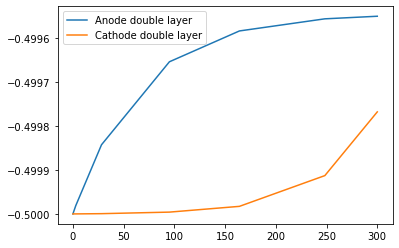

In [308]:
from matplotlib import pyplot as plt
for var in solution.y:
    plt.plot(solution.t,var)
    
plt.legend(['Anode double layer','Cathode double layer'])

For now, the battery double layer potentials simply go to those values needed to sustain the current density.

## Future To-Do List
- Add and reference figures
- Implement more realistic electrolyte diffusion
- Implement solid state diffusion
- Calculate anode voltage based on concentration of lithium
- Expand to P2D

## List of Symbols
